In [43]:
# Install necessary libraries
import os
import random
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')

train_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Train'
test_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Test'
val_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Validation'
dataset_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/samples'

# Separar dataset a test, train y validation
if False:
  all_images = [f for f in os.listdir(dataset_path)] #if f.endswith('.png')

  random.shuffle(all_images)

  total = len(all_images)
  test_split = int(0.2 * total)
  test_images  = all_images[:test_split]
  train_images = all_images[test_split:]

  val_split = int(0.2 * len(train_images))
  val_images = train_images[:val_split]
  train_images = train_images[val_split:]

  def move_images(images, src_folder, dst_folder):
      for img in images:
          shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

  move_images(train_images, dataset_path, train_path)
  move_images(val_images, dataset_path, val_path)
  move_images(test_images, dataset_path, test_path)

  print(f"Imágenes movidas: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imágenes movidas: Train=685, Val=171, Test=214


In [44]:
#Importamos el dataset
IMG_SIZE = (200, 50)
def load_dataset(path, img_size=IMG_SIZE):
    X = []
    Y = []

    for filename in os.listdir(path):
      label = filename[:5]
      img = Image.open(os.path.join(path, filename)).convert('L') # Convertir a escala de grises
      #reshape in case is not 200x50
      if img.size != img_size:
        img = img.resize(img_size)
      X.append(np.array(img) / 255.0)
      Y.append(label)
      x, y = np.array(X), np.array(Y)
      x = x[..., np.newaxis]
    return x, y

x_train, y_train = load_dataset(train_path)
x_test, y_test = load_dataset(test_path)
x_val, y_val = load_dataset(val_path)

Label: 3p67n


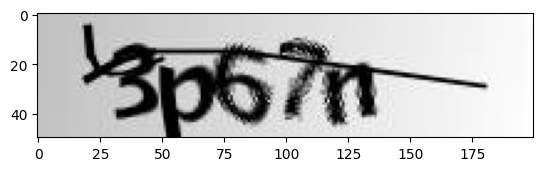

Label: wdww8


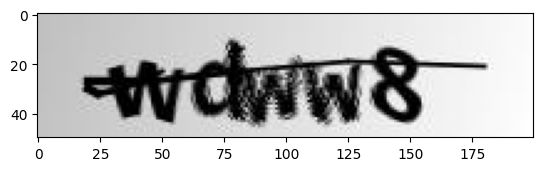

Label: mxyxw


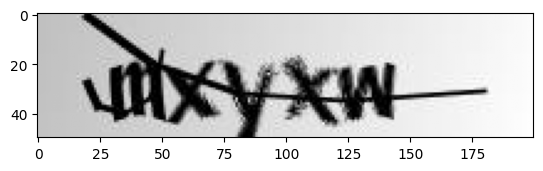

Label: gn2xy


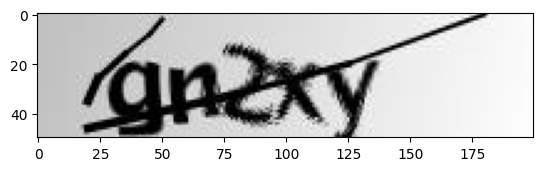

Label: c2fb7


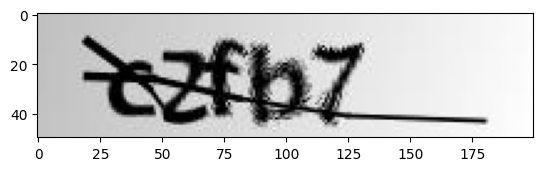

In [45]:
for i in range(5):
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    print("Label:", y_train[i])
    plt.show()

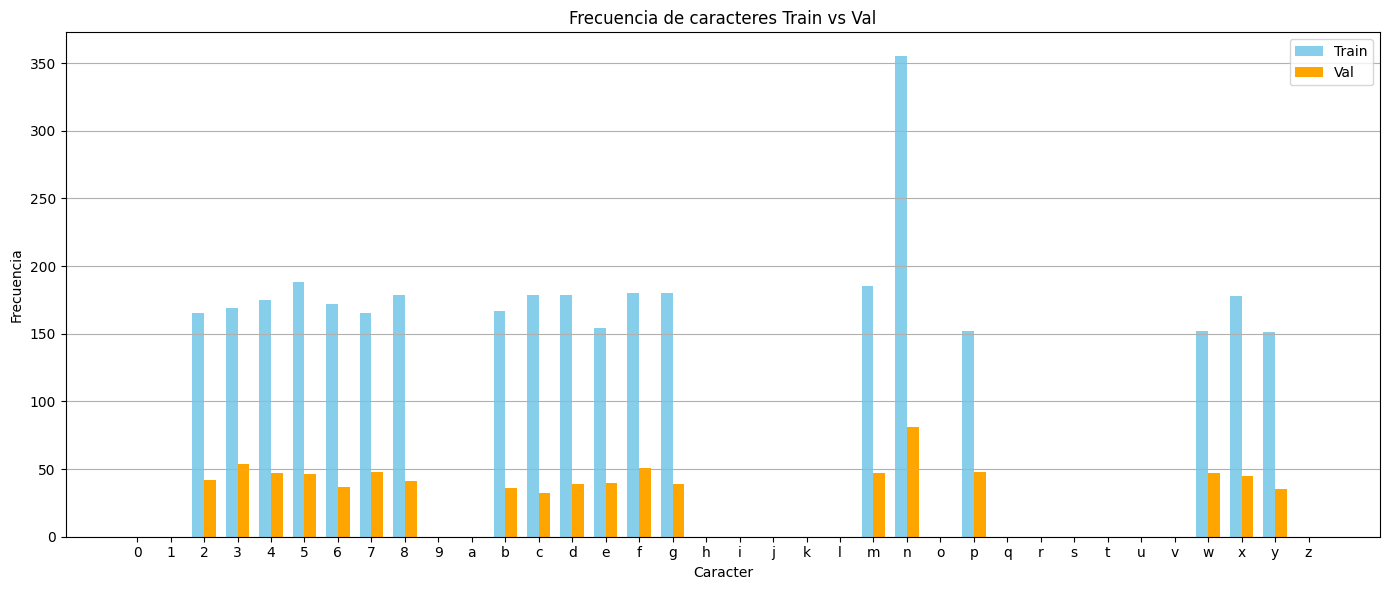

In [46]:
# Graficas frecuencia de caracteres
from collections import Counter
import string

def count_chars(labels):
  all_chars = ''.join(labels)
  char_counts = Counter(all_chars)

  return char_counts

def plot_char_frequencies(labels1, labels2, labels1_cat = 'Train', labels2_cat = 'Val', color1 = 'skyblue', color2 = 'orange'):
  train_char_counts = count_chars(labels1)
  val_char_counts_ = count_chars(labels2)

  # Orden consistente: 0-9, a-z
  charset = list(string.digits + string.ascii_lowercase)
  train_counts = [train_char_counts.get(c, 0) for c in charset]
  val_counts = [val_char_counts_.get(c, 0) for c in charset]
  # Posiciones para las barras
  x = np.arange(len(charset))
  width = 0.35

  plt.figure(figsize=(14, 6))
  plt.bar(x - width/2, train_counts, width, label= labels1_cat, color=color1)
  plt.bar(x + width/2, val_counts,  width, label= labels2_cat,  color=color2)
  plt.xticks(x, charset)
  plt.xlabel('Caracter')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de caracteres {labels1_cat} vs {labels2_cat}')
  plt.legend()
  plt.grid(axis='y')
  plt.tight_layout()
  plt.show()

plot_char_frequencies(y_train, y_val)

In [47]:
# Funcion para determinar imagenes a augmentar
def augment_captcha(path, labels, min_threshold = 250, max_threshold = 300):
  train_count = count_chars(labels)
  train_files = [f for f in os.listdir(path)]
  #train_files = [label + ".png" for label in labels]

  rare_chars = {c for c, count in train_count.items() if count < min_threshold}
  print("Caracteres raros:", rare_chars)
  dominant_chars = {c for c, count in train_count.items() if count > max_threshold}
  print("Caracteres dominantes:", dominant_chars)

  # Filtrar imágenes que contengan al menos un caracter raro y ninún dominante
  imgs_to_augment = [f for f in train_files if any(c in os.path.splitext(f)[0] for c in rare_chars) and not any(c in dominant_chars for c in os.path.splitext(f)[0])]
  return imgs_to_augment


In [48]:
# Augmentación de imágenes
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

augmented_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/TrainAug'

train_datagen = ImageDataGenerator(
    rotation_range=6,
    brightness_range=[0.2, 1.6],
    width_shift_range=0.03,
    height_shift_range=0.03,
    zoom_range=0.2,
    shear_range=8,
)

def pad_and_resize(image, pad=15):
    padded = ImageOps.expand(image, border=pad, fill=255)
    resized = padded.resize(IMG_SIZE)
    return resized


def augment_images(imgs_to_augment, AUGS_PER_IMAGE = 1):
  aug_imgs = []
  new_filenames = []
  for img_file in imgs_to_augment:
      label = os.path.splitext(img_file)[0]
      img_path = os.path.join(train_path, img_file)
      image = Image.open(img_path).convert("L")
      image = pad_and_resize(image)
      x = img_to_array(image)
      x = x[np.newaxis, ...]

      i = 0
      for batch in train_datagen.flow(x, batch_size=1):
          aug_img = array_to_img(batch[0])
          new_filename = f"{label}_aug{i+1}.png"
          # aug_img.save(os.path.join(augmented_path, new_filename))
          aug_img.save(os.path.join(train_path, new_filename))
          aug_imgs.append(aug_img)
          new_filenames.append(new_filename)
          i += 1
          if i >= AUGS_PER_IMAGE:
              break
  print("Imagenes augmentadas:", len(aug_imgs))

  for i in range(5):
    print(new_filenames[i])
    plt.imshow(aug_imgs[i], cmap='gray')
    plt.show()

Caracteres raros: {'7', 'e', 'm', '4', 'w', 'x', 'f', 'y', '8', '2', 'd', 'b', 'c', '3', 'g', 'p', '5', '6'}
Caracteres dominantes: {'n'}
Imagenes augmentadas: 400
wdww8_aug1.png


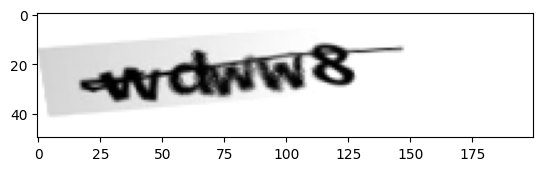

mxyxw_aug1.png


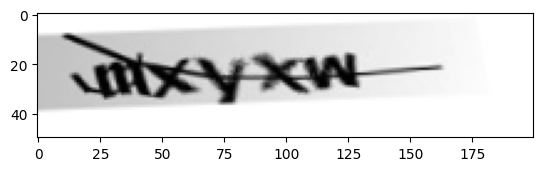

c2fb7_aug1.png


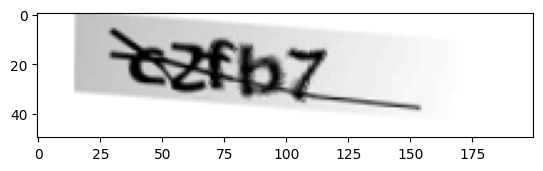

gc83b_aug1.png


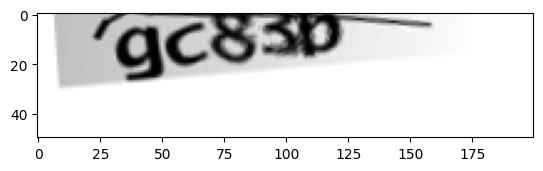

cdcb3_aug1.png


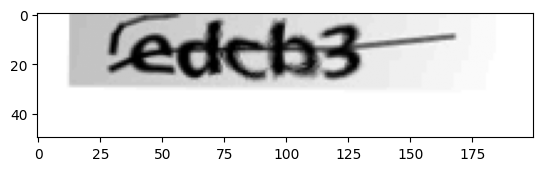

In [49]:
# Balancear
imgs_to_augment = augment_captcha(train_path, y_train)
augment_images(imgs_to_augment)

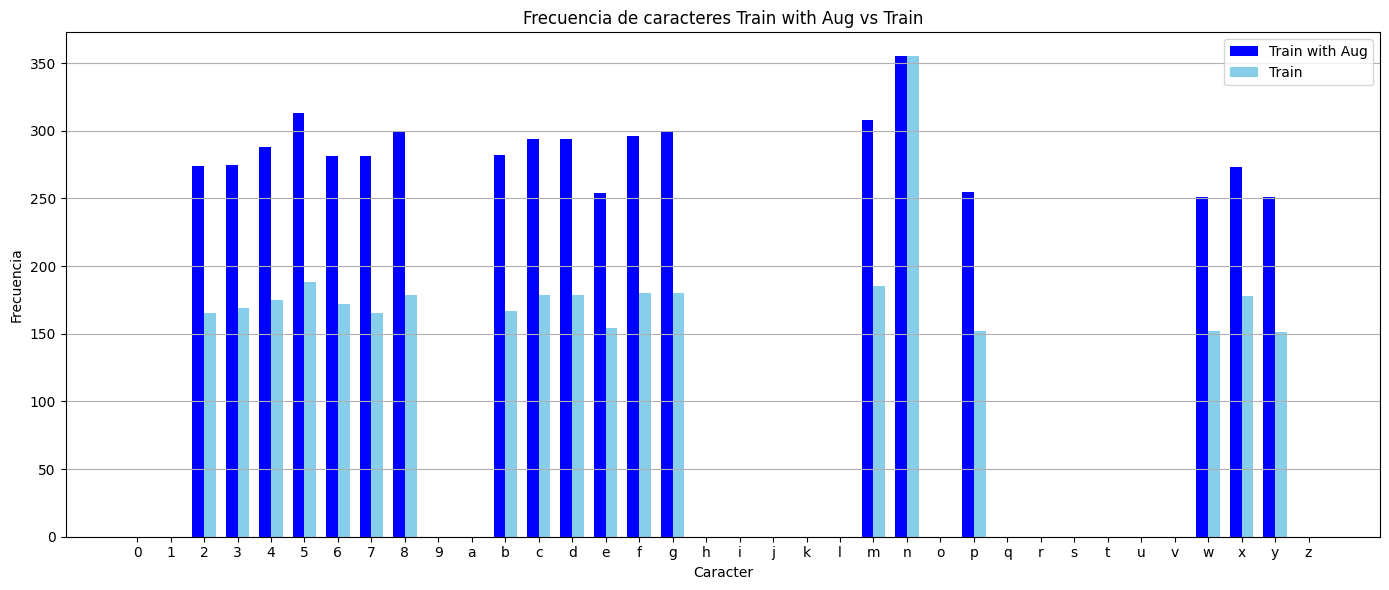

In [50]:
# Cargar el dataset de train con las augmentadas
x_train_aug, y_train_aug = load_dataset(train_path)

# Graficamos para ver las diferencias entre frecuencias
plot_char_frequencies(y_train_aug, y_train, 'Train with Aug', 'Train', 'blue', 'skyblue')

In [ ]:
# Volver a balancear
imgs_to_augment = augment_captcha(train_path, y_train_aug, 250, 300)
augment_images(imgs_to_augment, 2)

In [ ]:
# Generar muchas más imagenes
augment = [f for f in os.listdir(train_path)]
augment_images(augment, 1)

In [42]:
# BORRAR IMAGENES AUGMENTADAS
for filename in os.listdir(train_path):
    if '_aug' in filename:              # and filename.endswith('.png')
        file_path = os.path.join(train_path, filename)
        os.remove(file_path)

In [51]:
list_of_files = os.listdir(train_path)
print("Total de imágenes en el dataset de entrenamiento:", len(list_of_files))

Total de imágenes en el dataset de entrenamiento: 1085


In [52]:
from sklearn.preprocessing import LabelEncoder

# Codificar (encode) las etiquetas
all_labels = np.concatenate([y_train_aug, y_val, y_test])

unique_chars = sorted(set(char for label in all_labels for char in label))
# print("Caracteres únicos del dataset:", unique_chars)

encoder = LabelEncoder()
encoder.fit(unique_chars)

def split_and_encode_labels(y_raw, encoder):
    num_chars = 5 # Cada CAPTCHA tiene 5 caracteres
    y_splits = [[] for _ in range(num_chars)]

    for label in y_raw:
        for i, c in enumerate(label):
            y_splits[i].append(encoder.transform([c])[0])

    return np.array(y_splits).T

print("Mapeo de caracteres a números:")
for char in unique_chars:
    print(f"{char} -> {encoder.transform([char])[0]}")

y_train_encoded = split_and_encode_labels(y_train_aug, encoder)
y_val_encoded = split_and_encode_labels(y_val, encoder)
y_test_encoded = split_and_encode_labels(y_test, encoder)

Mapeo de caracteres a números:
2 -> 0
3 -> 1
4 -> 2
5 -> 3
6 -> 4
7 -> 5
8 -> 6
b -> 7
c -> 8
d -> 9
e -> 10
f -> 11
g -> 12
m -> 13
n -> 14
p -> 15
w -> 16
x -> 17
y -> 18


In [53]:
# Formatear 'y' para el fit (diccionario de los chars con las labels)
y_train_dict = {
    'char1': y_train_encoded[:, 0],
    'char2': y_train_encoded[:, 1],
    'char3': y_train_encoded[:, 2],
    'char4': y_train_encoded[:, 3],
    'char5': y_train_encoded[:, 4],
}

y_val_dict = {
    'char1': y_val_encoded[:, 0],
    'char2': y_val_encoded[:, 1],
    'char3': y_val_encoded[:, 2],
    'char4': y_val_encoded[:, 3],
    'char5': y_val_encoded[:, 4],
}

y_test_dict = {
    'char1': y_test_encoded[:, 0],
    'char2': y_test_encoded[:, 1],
    'char3': y_test_encoded[:, 2],
    'char4': y_test_encoded[:, 3],
    'char5': y_test_encoded[:, 4],
}


In [54]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def get_model_deep(input_shape):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=l2(0.02))(input_tensor)
    x = Conv2D(32, kernel_size=3, activation="relu", padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(x)
    # x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(x)

    # Define the five output layers
    output1 = Dense(len(unique_chars), activation='softmax', name='char1')(x)
    output2 = Dense(len(unique_chars), activation='softmax', name='char2')(x)
    output3 = Dense(len(unique_chars), activation='softmax', name='char3')(x)
    output4 = Dense(len(unique_chars), activation='softmax', name='char4')(x)
    output5 = Dense(len(unique_chars), activation='softmax', name='char5')(x)

    # Create the model with one input and five outputs
    model = Model(inputs=input_tensor, outputs=[output1, output2, output3, output4, output5])

    model.compile(optimizer= Adam(learning_rate=0.001), # Default: 0.001
                    loss = "sparse_categorical_crossentropy",
                    metrics=['accuracy'] * 5)
    return model

In [55]:
# model = get_model_deep((x_train_aug[0].shape))
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 50, 200,   │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 50, 200,   │      4,640 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 25, 100,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 25, 100,   │          0 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 80000)     │          0 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │  2,560,032 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char1 (Dense)       │ (None, 19)        │        627 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char2 (Dense)       │ (None, 19)        │        627 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char3 (Dense)       │ (None, 19)        │        627 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char4 (Dense)       │ (None, 19)        │        627 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char5 (Dense)       │ (None, 19)        │        627 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,135,936 (19.59 MB)

 Trainable params: 2,567,967 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,567,969 (9.80 MB)

In [60]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Model'
checkpoint_path = os.path.join(model_path, 'Bueno.weights.h5')
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                            save_weights_only = True,
                            save_freq = "epoch",
                            mode= 'min',
                            monitor = "val_loss",
                            save_best_only = True,
                            verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model = get_model_deep((x_train_aug[0].shape))

# Cargar pesos guardados del modelo
model.load_weights(checkpoint_path)

In [61]:
history = model.fit(x_train_aug, y_train_dict,
                    epochs=5, batch_size=64,
                    validation_data=(x_val, y_val_dict),
                    callbacks = [checkpoint],
                    verbose=1)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - char1_accuracy: 0.8121 - char1_loss: 0.6170 - char2_accuracy: 0.7976 - char2_loss: 0.6703 - char3_accuracy: 0.7784 - char3_loss: 0.7299 - char4_accuracy: 0.7314 - char4_loss: 0.8686 - char5_accuracy: 0.7892 - char5_loss: 0.7156 - loss: 5.1246
Epoch 1: val_loss improved from inf to 3.20229, saving model to /content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Model/Bueno.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - char1_accuracy: 0.8121 - char1_loss: 0.6175 - char2_accuracy: 0.7968 - char2_loss: 0.6715 - char3_accuracy: 0.7770 - char3_loss: 0.7337 - char4_accuracy: 0.7310 - char4_loss: 0.8698 - char5_accuracy: 0.7884 - char5_loss: 0.7184 - loss: 5.1345 - val_char1_accuracy: 0.9532 - val_char1_loss: 0.1388 - val_char2_accuracy: 0.9415 - val_char2_loss: 0.2397 - val_char3_accuracy: 0.8772 - val_char3_loss: 0.4019 - val_char4_accuracy: 0.8363 - val_char4_loss: 0.5640 - val_char5_accuracy: 0.9181 - val_cha

In [ ]:
# Guardar modelo exacto
# model.save(checkpoint_path)

In [58]:
import keras

# Importar modelo exacto
model = keras.models.load_model(os.path.join(model_path, 'Bueno.keras'))

In [62]:
# Mostrar resultados del entrenamiento
import pandas as pd
from tabulate import tabulate

hist = history.history
data = []

for i in range(5):
    train_key = f'char{i+1}_accuracy'
    val_key = f'val_char{i+1}_accuracy'

    if train_key in hist and val_key in hist:
        # Accuracy de entrenamiento
        acc_train = hist[train_key]
        max_acc_train = max(acc_train)
        max_epoch_train = acc_train.index(max_acc_train) + 1
        last_acc_train = acc_train[-1]
        mean_acc_train = sum(acc_train) / len(acc_train)

        # Accuracy de validación
        acc_val = hist[val_key]
        max_acc_val = max(acc_val)
        max_epoch_val = acc_val.index(max_acc_val) + 1
        last_acc_val = acc_val[-1]
        mean_acc_val = sum(acc_val) / len(acc_val)

        # Agregar fila a la tabla
        data.append([
            f'Char {i+1}',
            f"{max_acc_train:.4f}, {max_epoch_train}",
            f"{max_acc_val:.4f}, {max_epoch_val}",
            f"{last_acc_train:.4f}",
            f"{last_acc_val:.4f}",
            f"{mean_acc_train:.4f}",
            f"{mean_acc_val:.4f}"
        ])

# Crear DataFrame
columns = [
    "Caracter",
    "Mejor acc (train/época)",
    "Mejor acc (val/época)",
    "Última acc (train)",
    "Última acc (val)",
    "Promedio acc (train)",
    "Promedio acc (val)"
]
df = pd.DataFrame(data, columns=columns)

# Mostrar tabla con líneas verticales y encabezados
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Mostrar el menor loss (entrenamiento)
if 'loss' in hist:
    min_loss = min(hist['loss'])
    epoch = hist['loss'].index(min_loss) + 1
    print(f"\nMenor loss (entrenamiento): {min_loss:.4f} en la época {epoch}")

# Mostrar el menor val_loss (validación)
if 'val_loss' in hist:
    min_val_loss = min(hist['val_loss'])
    epoch = hist['val_loss'].index(min_val_loss) + 1
    print(f"Menor val_loss (validación): {min_val_loss:.4f} en la época {epoch}")

╒════════════╤═══════════════════════════╤═════════════════════════╤══════════════════════╤════════════════════╤════════════════════════╤══════════════════════╕
│ Caracter   │ Mejor acc (train/época)   │ Mejor acc (val/época)   │   Última acc (train) │   Última acc (val) │   Promedio acc (train) │   Promedio acc (val) │
╞════════════╪═══════════════════════════╪═════════════════════════╪══════════════════════╪════════════════════╪════════════════════════╪══════════════════════╡
│ Char 1     │ 0.9429, 5                 │ 0.9532, 1               │               0.9429 │             0.9415 │                 0.8988 │               0.9439 │
├────────────┼───────────────────────────┼─────────────────────────┼──────────────────────┼────────────────────┼────────────────────────┼──────────────────────┤
│ Char 2     │ 0.9318, 5                 │ 0.9415, 1               │               0.9318 │             0.9181 │                 0.8829 │               0.9029 │
├────────────┼────────────────────

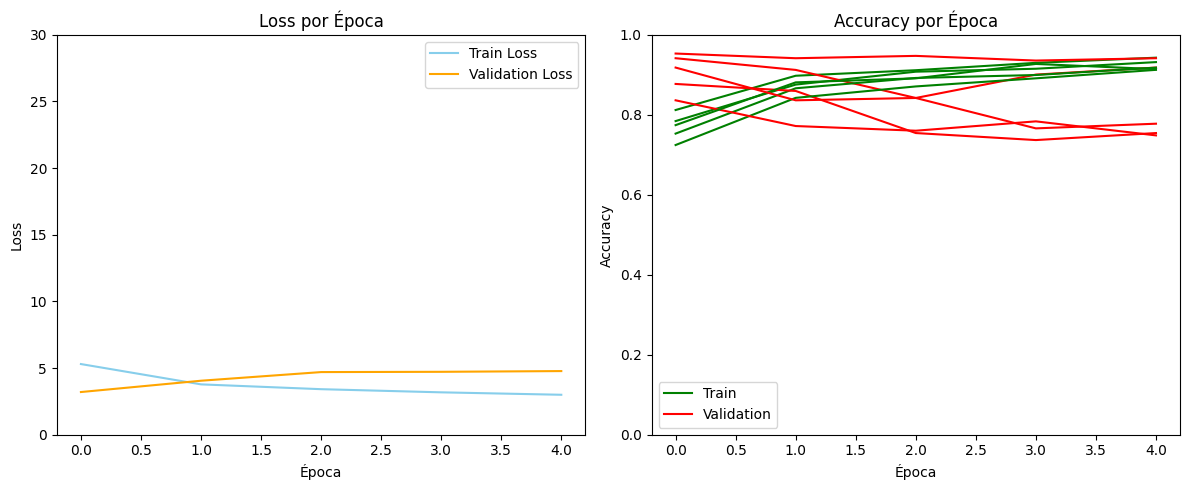

In [63]:
# Graficar resultados
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss', color='skyblue')
plt.plot(hist['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.ylim(0, 30)
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    # Solo agregar label en la primera iteración
    train_label = 'Train' if i == 0 else None
    val_label = 'Validation' if i == 0 else None

    plt.plot(hist[f'char{i+1}_accuracy'], label=train_label, color='green')
    plt.plot(hist[f'val_char{i+1}_accuracy'], label=val_label, color='red')

plt.title('Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


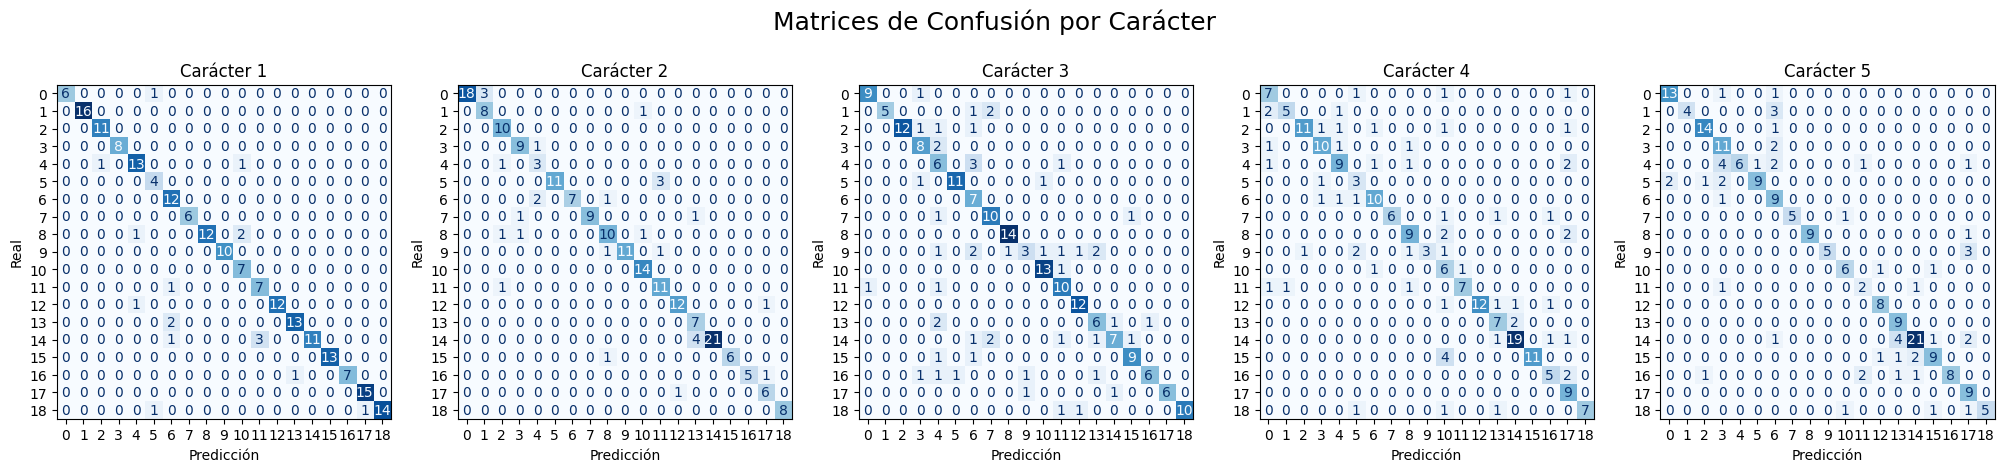

In [64]:
# Matrices de confusión y reporte de clasificación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = model.predict(x_test)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Matrices de Confusión por Carácter', fontsize=18)

# Iterar sobre los 5 caracteres
for i in range(5):
    key = f'char{i+1}'
    y_true_i = y_test_dict[key]
    y_pred_i = np.argmax(y_pred[i], axis=1)

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true_i, y_pred_i)

    # Mostrar en subplot correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Carácter {i+1}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

In [22]:
# Predicciones
def predict(model, imgs, labels=None):
  predictions = model.predict(imgs)
  decoded_predictions = []
  for i in range(predictions[0].shape[0]):
      chars = [encoder.classes_[np.argmax(pred[i])] for pred in predictions]
      decoded_predictions.append(''.join(chars))

  for i in range(5):
      if labels is not None:
          random_index = random.randint(0, len(imgs) - 1)
          print(f"Predicción: {decoded_predictions[random_index]}")
          print(f"Real: {''.join([encoder.classes_[c] for c in labels[random_index]])}")
          plt.imshow(imgs[random_index], cmap='gray')
      else:
        print(f"Predicción: {decoded_predictions[i]}")
        plt.imshow(imgs[i], cmap='gray')
      plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Predicción: cg3mm
Real: mm3nn


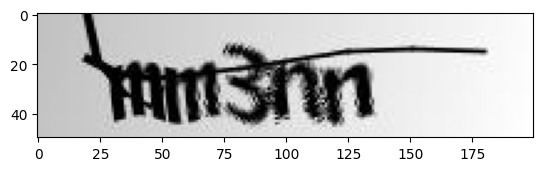

Predicción: ggde5
Real: mnef5


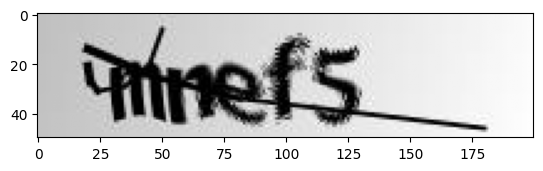

Predicción: gx782
Real: myf82


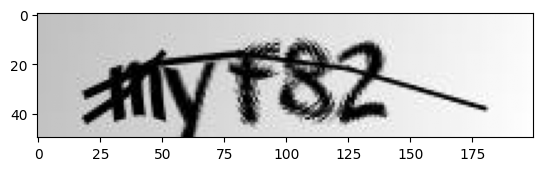

Predicción: 3n7pm
Real: 5p3mm


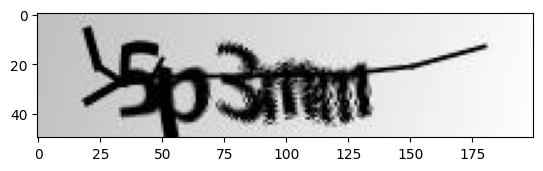

Predicción: nwmd8
Real: pxne8


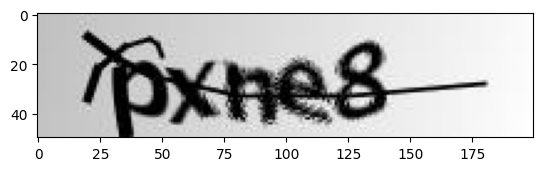

In [23]:
predict(model, x_test, y_test_encoded)

In [65]:
def evaluate_model(model, scaled_test_images, test_labels):
    results = model.evaluate(scaled_test_images, test_labels, return_dict=True)

    # Imprimir el loss general
    print(f"Test Loss: {results['loss']:.4f}")

    # Imprimir accuracy por carácter
    for i in range(1, 6):
        key = f'char{i}_accuracy'
        if key in results:
            print(f"Accuracy char{i}: {results[key]:.4f}")

# Evaluar el modelo con los datos de test
evaluate_model(model, x_test, y_test_dict)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - char1_accuracy: 0.9264 - char1_loss: 0.2610 - char2_accuracy: 0.8676 - char2_loss: 0.3275 - char3_accuracy: 0.7530 - char3_loss: 0.6810 - char4_accuracy: 0.7244 - char4_loss: 1.0308 - char5_accuracy: 0.7708 - char5_loss: 0.8536 - loss: 4.9122
Test Loss: 4.9023
Accuracy char1: 0.9206
Accuracy char2: 0.8692
Accuracy char3: 0.7664
Accuracy char4: 0.7290
Accuracy char5: 0.7570


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicción: 7wc75


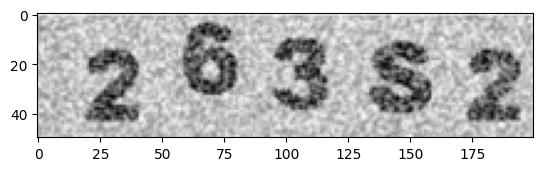

Predicción: 7wc75


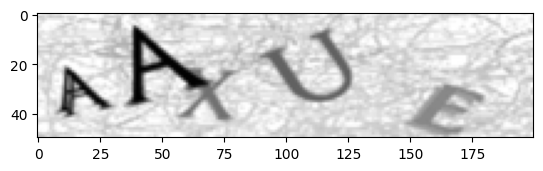

Predicción: 7wc75


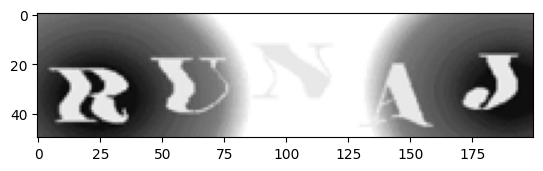

Predicción: bd447


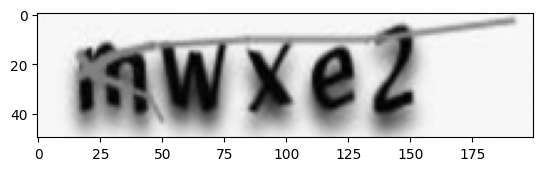

Predicción: f3c57


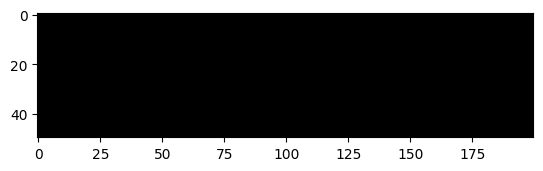

In [66]:
# Para probar con imagenes reales
real_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Real'

x_real, y_real = load_dataset(real_path)

predict(model, x_real)